# Group project

By delivering this notebook, we confirm that the group project was developed by the following students.

## Student 1: George McGuigan

## Student 2: Isabella Russo


The group project will focus on analysing data on flights in the US.

Unless otherwise specified, the problems can be solved using either Spark or Pandas.

Some useful links:

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)


## Colab setup

The following cell will install Spark, if the notebook is running on COLAB. Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing)

In [1]:
#Run this cell to install Spark on Colab
import os

if 'COLAB_GPU' in os.environ : 
    !apt-get install openjdk-8-jdk-headless
    !pip install pyspark==3.1.2
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.1-s_2.12.jar pyspark-shell'

    from google.colab import drive
    drive.mount('/content/drive')



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

## Local setup

For running the group project locally, you should create a directory named **data** in the directory where you have this notebook. Then, you should download to the **data** directory the files in the following link: [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing).

## Initialization

Import libraries. 

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors

plt.style.use('seaborn')

print(pyspark.__version__)


3.1.2


Let's start spark session and set *log* level to ERROR.

In [ ]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if 'COLAB_GPU' in os.environ : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.1-s_2.12.jar')
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar')


spark.sparkContext.setLogLevel("ERROR")

## Data selection

This cell controls the dataset you will be using. Note that this cell will control the path to the files, dependening on the platform you are using to run the code.


In [ ]:
# Comment the following 
flightsF = "sample.csv"
#flightsF = "complete.csv"
#flightsF = "data-2009.csv"
#flightsF = "data-2010.csv"
#flightsF = "data-2011.csv"
#flightsF = "data-2012.csv"
#flightsF = "data-2013.csv"
#flightsF = "data-2014.csv"
#flightsF = "data-2015.csv"
#flightsF = "data-2016.csv"
#flightsF = "data-2017.csv"
#flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/data/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/data/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/data/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")




## Datasets

This section describes the datasets you have available for your analysis.

### Flights

The flights dataset, generated from data available at [https://www.transtats.bts.gov/DataIndex.asp](https://www.transtats.bts.gov/DataIndex.asp), includes the following columns:

* FL_DATE: date of the flight (format: yyyy-mm-dd)
* OP_CARRIER: carrier code
* OP_CARRIER_FL_NUM: carrier flight number
* ORIGIN: origin airport (using IATA codes)
* DEST: destination airport (using IATA codes)
* CRS_DEP_TIME: scheduled local departure time (format for all times: hh:mm)
* DEP_TIME: actual departure time
* DEP_DELAY: departure delay, in minutes
* TAXI_OUT: taxi out time
* WHEELS_OFF: actual local wheel off time
* WHEELS_ON: actual local wheel on time
* TAXI_IN: actual local taxi in time
* CRS_ARR_TIME: scheduled local arrival time
* ARR_TIME: actual arrival time
* ARR_DELAY: arrival delay, in minutes
* CANCELLED: 1 if the flight has been cancelled; 0 otherwise
* CANCELLATION_CODE: code of cancelation (A = carrier, B = weather, C = NAS, D = security)
* DIVERTED: 1 if the flight has been diverted; 0 otherwise
* CRS_ELAPSED_TIME: estimated elapsed time
* ACTUAL_ELAPSED_TIME: actual elapsed time
* AIR_TIME: flight time, in minutes
* DISTANCE: flight distance, in miles
* CARRIER_DELAY: delay due to carrier, in minutes
* WEATHER_DELAY: delay due to weather, in minutes
* NAS_DELAY: delay due to NAS, in minutes
* SECURITY_DELAY: delay due to security, in minutes
* LATE_AIRCRAFT_DELAY: delay due to late aircraft, in minutes

The following data files are available:

* complete.csv : complete data set, including data from 2009 to 2018
* sample.csv : sample data set, including data from July 1 to July 15, from years 2009 to 2018
* data-20xx.csv : data set for a particular year

Load the dataset into flightsDF dataframe and register flights under view name **flights**. We are setting the schema programmatically, because inferring the schema in a very large dataframe is slow.


In [ ]:
flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights")

flightsDF.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-07-01|        XE|             5

### Airports

The airports dataset includes the information about US airports - soure: [https://datahub.io/core/airport-codes](https://datahub.io/core/airport-codes).

This dataset includes the following columns:

* ident: identifier
* type: type of airport
* name: name of airport
* elevation_ft: altitude, in feets
* continent: code of continent
* iso_country: coide of country
* iso_regio: code of region
* municipality: city
* gps_code: code of GPS
* iata_code: IATA code of aurport
* local_code: local code of airport
* coordinates: coordinates of airport

Load the dataset into airportDF dataframe and register airports under view name **airports**.


In [ ]:
airportsDF = spark.read.option("header", True).option("inferSchema",True).csv(AIRPORTS_FILENAME)

airportsDF.createOrReplaceTempView("airports")

airportsDF.show(3)


+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
+-----+-------------+--------------------+------------+---------+-----------+-----

Exemplify how you can plot information about airports.

Plotting airport location - using altitude for different color


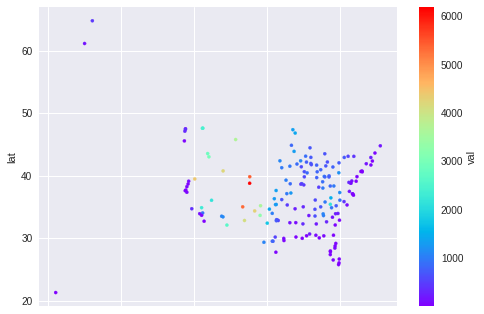

In [ ]:
airportLocDF = spark.sql("""SELECT FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))) AS lon,
                                    FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))) AS lat,
                                    elevation_ft AS val
                        FROM airports 
                        WHERE type = 'large_airport' AND continent = 'NA' AND iso_country = 'US'""")

print('Plotting airport location - using altitude for different color')
airportLocPD = airportLocDF.toPandas()
airportLocPD.plot(x="lon",y="lat",c="val",s=10,cmap="rainbow",kind="scatter")


### Public holidays

Dates of public holidays in the US.

This dataset includes the following columns:

* Date: date (format: yyyy-mm-dd)
* Holiday: name of the holiday
* WeekDay: day of week
* Month: month (1-12)
* Day: day (1-31)
* Year: year (2002-2021)

Load the dataset into holidaysDF dataframe and register holidays under view name **holidays**.


In [ ]:
holidaysDF = spark.read.option("header", True).option("inferSchema",True).csv(HOLIDAYS_FILENAME)

holidaysDF.createOrReplaceTempView("holidays")

holidaysDF.show(3)


+----------+-----------+-------+-----+---+----+
|      Date|    Holiday|WeekDay|Month|Day|Year|
+----------+-----------+-------+-----+---+----+
|2004-07-04|4th of July| Sunday|    7|  4|2004|
|2005-07-04|4th of July| Monday|    7|  4|2005|
|2006-07-04|4th of July|Tuesday|    7|  4|2006|
+----------+-----------+-------+-----+---+----+
only showing top 3 rows



## Problem 0 [1 point]

We start by executing some simple statistics to compare the execution time between Spark and Pandas.


### Code: Spark

In [ ]:
start_time = time.time()

flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result = spark.sql("SELECT OP_CARRIER, count(*) AS num_flights FROM flights_new GROUP BY OP_CARRIER")
result.show()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))



+----------+-----------+
|OP_CARRIER|num_flights|
+----------+-----------+
|        UA|     192622|
|        NK|      25439|
|        AA|     266003|
|        NW|      14128|
|        EV|     185522|
|        B6|      97885|
|        DL|     303978|
|        OO|     240809|
|        F9|      36190|
|        YV|      38181|
|        US|      84928|
|        MQ|     114668|
|        OH|      24677|
|        HA|      29920|
|        XE|      31772|
|        G4|       5123|
|        YX|      12706|
|        AS|      68912|
|        CO|      21141|
|        FL|      43105|
+----------+-----------+
only showing top 20 rows

Runtime = 7.524178981781006


* Execution time for sample.csv: 11.90 sec
* Execution time for complete.csv: 181.03 sec

Using GPU @ Colab (go to Execution time menu and change the type of execution time to include GPU):

* Execution time for sample.csv: 7.94
* Execution time for complete.csv: 148.67


Using GPU is faster than CPU however you have a limited runtime.


### Code: Pandas library

In [ ]:
import pandas as pd
import time

start_time = time.time()
mySchema = {"FL_DATE": "str",
            "OP_CARRIER": "str",
            "OP_CARRIER_FL_NUM":"Int64",
            "ORIGIN":"str",
            "DEST":"str",
            "CRS_DEP_TIME":"str",
            "DEP_TIME":"str",
            "DEP_DELAY":"Int64",
            "TAXI_OUT":"Int64",
            "WHEELS_OFF":"str",
            "WHEELS_ON":"str",
            "TAXI_IN":"Int64",
            "CRS_ARR_TIME":"str",
            "ARR_TIME":"str",
            "ARR_DELAY":"Int64",
            "CANCELLED":"Int64",
            "CANCELLATION_CODE":"str",
            "DIVERTED":"Int64",
            "CRS_ELAPSED_TIME":"Int64",
            "ACTUAL_ELAPSED_TIME":"Int64",
            "AIR_TIME":"Int64",
            "DISTANCE":"Int64",
            "CARRIER_DELAY":"Int64",
            "WEATHER_DELAY":"Int64",
            "NAS_DELAY":"Int64",
            "SECURITY_DELAY":"Int64",
            "LATE_AIRCRAFT_DELAY":"Int64"
           }

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)
result = dataframe[["FL_DATE","OP_CARRIER"]].groupby("OP_CARRIER").count()
print(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


            FL_DATE
OP_CARRIER         
9E            44539
AA           266003
AS            68912
B6            97885
CO            21141
DL           303978
EV           185522
F9            36190
FL            43105
G4             5123
HA            29920
MQ           114668
NK            25439
NW            14128
OH            24677
OO           240809
UA           192622
US            84928
VX            15862
WN           465495
XE            31772
YV            38181
YX            12706
Runtime = 26.99401569366455


* Execution time for sample.csv: 27.70
* Execution time for complete.csv: after 20 minutes it stops

**Discuss the results you have obtained:**

Runtime for spark is about half the time compared with pandas.
This is because spark is multi-threaded while as pandas is single-threaded. In addition spark can be executed in a distributed way whereas pandas executes each step as it reaches it. In these case I was not possible to calculate the runtime of the complete dataset with pandas.
While the complete.csv dataset was unable to run on pandas, timing out after 20 minutes, it was able to run in 140 seconds using spark. This suggests that when working with large datasets, we should execute our functions using spark.




---




## Problem 1 [4 points]

In this first problem, you should compute a set of statistics on the data.


### Top-20 airports with more flights (include the name of the airport)

+--------------------+------+
|                name| count|
+--------------------+------+
|Hartsfield Jackso...|292928|
|Chicago O'Hare In...|225636|
|Dallas Fort Worth...|188344|
|Denver Internatio...|178326|
|Los Angeles Inter...|165664|
|Phoenix Sky Harbo...|126822|
|George Bush Inter...|125430|
|San Francisco Int...|123106|
|McCarran Internat...|109790|
|Minneapolis-St Pa...|102290|
|Detroit Metropoli...| 98756|
|Seattle Tacoma In...| 98394|
|Charlotte Douglas...| 98090|
|Orlando Internati...| 93316|
|General Edward La...| 89092|
|Salt Lake City In...| 88244|
|Newark Liberty In...| 85280|
|John F Kennedy In...| 81750|
|Baltimore/Washing...| 77742|
|  La Guardia Airport| 76500|
+--------------------+------+



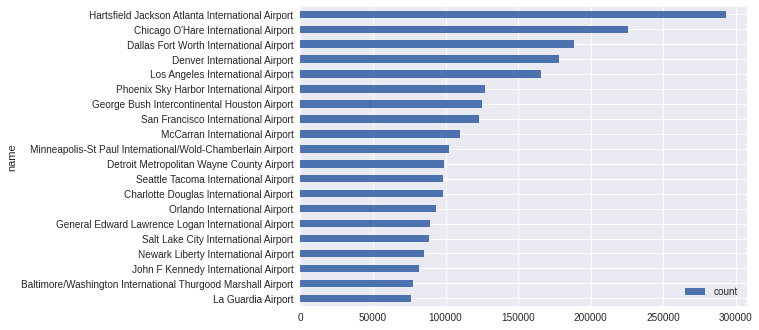

In [ ]:

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result1 = spark.sql("""SELECT name, count(ORIGIN)+count(DEST) AS count FROM flights
                    JOIN airports ON airports.iata_code=flights.ORIGIN where cancelled=0 GROUP BY name ORDER BY 
                    count desc LIMIT 20""")

result1.show(20)
#for the plot
pandasDf = result1.toPandas()
pandasDf.set_index("name",inplace = True)
pandasDf.plot.barh().invert_yaxis()

### Top-20 days with more flights

In [ ]:
days=spark.sql("""SELECT FL_DATE, count(*) AS count FROM flights where cancelled=0 
                    GROUP BY FL_DATE ORDER BY 
                    count desc""").show(20)

+----------+-----+
|   FL_DATE|count|
+----------+-----+
|2018-07-13|21851|
|2018-07-09|21737|
|2018-07-11|21613|
|2018-07-12|21539|
|2018-07-10|21397|
|2018-07-08|21161|
|2018-07-15|20595|
|2018-07-06|20065|
|2018-07-01|19745|
|2018-07-02|19515|
|2018-07-05|19388|
|2009-07-10|19299|
|2009-07-06|19239|
|2009-07-09|19235|
|2013-07-15|19178|
|2009-07-15|19134|
|2009-07-13|19127|
|2009-07-08|19084|
|2013-07-12|19059|
|2009-07-14|19029|
+----------+-----+
only showing top 20 rows



### Periods with more flights: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)

In [ ]:
flightsDF.withColumn("DEP_TIME",to_timestamp("DEP_TIME")) \

import pyspark.sql.functions as spark_functions

dep_split = pyspark.sql.functions.split(flightsDF["DEP_TIME"], ' ')
flightsDF = flightsDF.withColumn('Time', spark_functions.concat(dep_split.getItem(1),spark_functions.lit(' '),dep_split.getItem(2)))

from pyspark.sql import functions as spark_functions
def time_sorter(DEP_TIME):
  if DEP_TIME < 1200:
    return "MORNING_FLIGHTS"
  elif DEP_TIME < 1800:
    return "AFTERNOON_FLIGHTS"
  else: 
    return "EVENING_FLIGHTS"

FLIGHTS1 = flightsDF.withColumn("DEP_TIME", spark_functions.regexp_replace("DEP_TIME", "\\:", ""))
FLIGHTS2 = FLIGHTS1.withColumn("DEP_TIME",col("DEP_TIME").cast("int"))

bins = udf(time_sorter, StringType() )

FLIGHTS3 = FLIGHTS2.withColumn("CATEGORIZED_DEP", bins("DEP_TIME"))

FLIGHTS3.createOrReplaceTempView("CATEGORIZED_FLIGHTS")

spark.sql("""SELECT CATEGORIZED_DEP, COUNT(*) as COUNT
            FROM CATEGORIZED_FLIGHTS
            WHERE CANCELLED = 0
            GROUP BY CATEGORIZED_DEP
            ORDER BY COUNT DESC
            """).show()

+-----------------+------+
|  CATEGORIZED_DEP| COUNT|
+-----------------+------+
|  MORNING_FLIGHTS|968632|
|AFTERNOON_FLIGHTS|824064|
|  EVENING_FLIGHTS|538781|
+-----------------+------+



### Top-20 airports with longer delays

In [ ]:
result2 = spark.sql("""SELECT name, round(AVG(DEP_DELAY),2) AS DELAY FROM flights
                    JOIN airports ON airports.iata_code=flights.ORIGIN where cancelled=0 GROUP BY name ORDER BY 
                    DELAY desc""")
result2.show(20)

+--------------------+-----+
|                name|DELAY|
+--------------------+-----+
|Hagerstown Region...|62.33|
|Laughlin Bullhead...| 40.8|
|Ogden Hinckley Ai...|38.25|
|Northeast Florida...|35.55|
|Jack Mc Namara Fi...|34.73|
|Barnstable Munici...|33.74|
|Scott AFB/Midamer...|33.53|
|Rickenbacker Inte...|31.48|
|Ogdensburg Intern...| 29.5|
|Portsmouth Intern...|29.31|
|Salina Municipal ...|29.16|
|Southwest Oregon ...|26.38|
|Martha's Vineyard...|24.69|
|North Central Wes...|24.19|
|Trenton Mercer Ai...|22.66|
|Garden City Regio...| 22.6|
|Stockton Metropol...|22.38|
|Concord-Padgett R...|22.04|
|Hattiesburg Laure...|21.62|
|St Petersburg Cle...|20.68|
+--------------------+-----+
only showing top 20 rows



### Top 10 carriers with longer delays

In [ ]:
result = spark.sql("""SELECT OP_CARRIER, round(AVG(DEP_DELAY),2) AS DELAY FROM flights
                    where cancelled=0 GROUP BY OP_CARRIER ORDER BY 
                    DELAY desc""")
result.show(10)

+----------+-----+
|OP_CARRIER|DELAY|
+----------+-----+
|        G4|20.82|
|        B6|16.66|
|        EV|16.31|
|        UA|16.15|
|        F9|15.94|
|        VX|14.93|
|        NK|14.19|
|        AA|12.63|
|        WN|12.62|
|        FL|12.17|
+----------+-----+
only showing top 10 rows



### Longer delays by period: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)


In [ ]:
spark.sql("""SELECT CATEGORIZED_DEP, round(AVG(DEP_DELAY),2) AS DELAY
            FROM CATEGORIZED_FLIGHTS
            WHERE CANCELLED = 0
            GROUP BY CATEGORIZED_DEP
            ORDER BY DELAY DESC
            """).show()



+-----------------+-----+
|  CATEGORIZED_DEP|DELAY|
+-----------------+-----+
|  EVENING_FLIGHTS|25.97|
|AFTERNOON_FLIGHTS|11.32|
|  MORNING_FLIGHTS| 3.97|
+-----------------+-----+



## Problem 2 [4 points]

Assume you want to create a web site to help travellers get information about flight delays. The web site would allow a user to find out information about delays for the flight she want to take. 
The information about delays should include at least 3 statistics - suggestion: the average delay in the same route of the same carrier in the last 7 days, 30 days, 365 days, similar but considering only flights in the same week day, but excluding holidays, etc.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user.

Write the code to build these indices - for each index, print 5 lines.

In [ ]:

flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/data/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/data/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/data/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")

In [ ]:
flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

last_7 = spark.sql(""" SELECT op_carrier, CONCAT(origin, " ", dest) as route, AVG(dep_delay) as delay
                      FROM flights_new
                      WHERE cancelled = 0 
                      AND fl_date BETWEEN DATE("2018-05-17") - INTERVAL 7 DAYS AND DATE("2018-05-17")
                      GROUP BY op_carrier, route""")


last_7_holiday = spark.sql(""" SELECT op_carrier, CONCAT(origin, " ", dest) as route, AVG(dep_delay) as delay
                      FROM flights_new LEFT JOIN holidays ON FL_DATE = date
                      WHERE cancelled = 0 and holiday IS NULL
                      AND fl_date BETWEEN DATE("2018-05-17") - INTERVAL 7 DAYS AND DATE("2018-05-17")
                      GROUP BY op_carrier, route""")


last_30 = spark.sql(""" SELECT op_carrier, CONCAT(origin, " ", dest) as route, AVG(dep_delay) as delay
                      FROM flights_new
                      WHERE cancelled = 0 
                      AND fl_date BETWEEN DATE("2018-05-17") - INTERVAL 30 DAYS AND DATE("2018-05-17")
                      GROUP BY op_carrier, route""")

last_30_holiday = spark.sql(""" SELECT op_carrier, CONCAT(origin, " ", dest) as route, AVG(dep_delay) as delay
                      FROM flights_new LEFT JOIN holidays ON FL_DATE = date
                      WHERE cancelled = 0 and holiday IS NULL
                      AND fl_date BETWEEN DATE("2018-05-17") - INTERVAL 30 DAYS AND DATE("2018-05-17")
                      GROUP BY op_carrier, route""")

last_365 = spark.sql(""" SELECT op_carrier, CONCAT(origin, " ", dest) as route, AVG(dep_delay) as delay
                      FROM flights_new
                      WHERE cancelled = 0 
                      AND fl_date BETWEEN DATE("2018-05-17") - INTERVAL 365 DAYS AND DATE("2018-05-17")
                      GROUP BY op_carrier, route""")

last_365_holiday = spark.sql(""" SELECT op_carrier, CONCAT(origin, " ", dest) as route, AVG(dep_delay) as delay
                      FROM flights_new LEFT JOIN holidays ON FL_DATE = date
                      WHERE cancelled = 0 and holiday IS NULL
                      AND fl_date BETWEEN DATE("2018-05-17") - INTERVAL 365 DAYS AND DATE("2018-05-17")
                      GROUP BY op_carrier, route""")


last_7.createOrReplaceTempView("last_7")
last_7_holiday.createOrReplaceTempView("last_7_holiday")
last_30.createOrReplaceTempView("last_30")
last_30_holiday.createOrReplaceTempView("last_30_holiday")
last_365.createOrReplaceTempView("last_365")
last_365_holiday.createOrReplaceTempView("last_365_holiday")



indices = spark.sql("""SELECT last_7.op_carrier, last_7.route, ROUND((last_7.delay/(SELECT MAX(delay) from last_7)),3) as index7,
                       ROUND((last_7_holiday.delay/(SELECT MAX(delay) from last_7_holiday)),3) as index7holiday,
                       ROUND((last_30.delay/(SELECT MAX(delay) from last_30)),3) as index30,
                       ROUND((last_30_holiday.delay/(SELECT MAX(delay) from last_30_holiday)),3) as index30holiday,
                       ROUND((last_365.delay/(SELECT MAX(delay) from last_365)),3) as index365,
                       ROUND((last_365_holiday.delay/(SELECT MAX(delay) from last_365_holiday)),3) as index365holiday
                       FROM last_7
                       JOIN last_7_holiday on last_7.op_carrier = last_7_holiday.op_carrier AND last_7.route = last_7_holiday.route
                       JOIN last_30 on last_7.op_carrier = last_30.op_carrier AND last_7.route = last_30.route
                       JOIN last_30_holiday on last_7.op_carrier = last_30_holiday.op_carrier AND last_7.route = last_30_holiday.route
                       JOIN last_365 on last_7.op_carrier = last_365.op_carrier AND last_7.route = last_365.route
                       JOIN last_365_holiday on last_7.op_carrier = last_365_holiday.op_carrier AND last_7.route = last_365_holiday.route
                      """).show(5)
                      


+----------+-------+------+-------------+-------+--------------+--------+---------------+
|op_carrier|  route|index7|index7holiday|index30|index30holiday|index365|index365holiday|
+----------+-------+------+-------------+-------+--------------+--------+---------------+
|        9E|JFK CMH| 0.104|        0.104|  0.055|         0.055|   0.015|           0.01|
|        9E|ORD CVG| 0.066|        0.066|  0.049|         0.049|   0.009|          0.009|
|        AA|DEN PHX|-0.004|       -0.004|  0.011|         0.011|   0.004|          0.004|
|        AA|PHL AUS| 0.039|        0.039|  0.017|         0.017|   0.006|          0.006|
|        AA|RNO DFW| 0.027|        0.027|  0.015|         0.015|   0.008|          0.008|
+----------+-------+------+-------------+-------+--------------+--------+---------------+
only showing top 5 rows



#### Discussion

We set our solution up in a way, where the user of the website is querying a preprocessed set of indices for each carrier-route combination, which is calculated once per day. The user will then be presented with the indices, showing the average delays of the chosen carrier on that route on the last 7/30/365 days - compared to the other carrier-route combinations. The same indices (7/30/365) are available excluding holidays, but the values are fairly similar (which makes sense as there are only a few holidays in a year).

This index information can then be easily combined with some visuals, where a value close to 1 is a longer delay and a value close to 0 is a shorter delay. The user will want to select a carrier-route close to 0. Tyically, indices go from 0-1, however our calculated indices also include small negative values. Those are caused by the negative delay (plane leaving ahead of the departure time) values in the dataset. Consequently, this means that negative values in the indices are to be interpreted by the user as a very punctual carrier-route.

Note that in the code we have chosen a reference date (2018-05-17) as an example to be able to make the last n day calculation. For this reason, also used the 2018 dataset instead of the sample dataset, because we needed a complete set of flights (When using the sample dataset the last 7 calculation was emptly bc there were no flights in that period). Ideally, the preprocessing of the indices would run on a dataset that spans only the last 365 days, so for a calculation at the current time, the preprocessing would be run on the dataset for 2021 and 2020. This way, we can reduce runtime by only considering data that is actually relevant for the index calculation (instead of using the complete file). By preprocessing once per day and then storing the indices, we can assure that the query of the user is not taking too long (running the entire preprocessing each time a user queries a carrier-route would take way too long and the user would leave the webpage).

## Problem 3 [4 points]

Transform the flights data to include a class, depending on the delay - SHORT, LONG - depending on whether the departure delay was less than 10 minutes, or greater or equal to 10 minutes.

Build and evaluate a classification model for the data.


Before we  train a model, we need to analyse the features which can be altered so it optimizes the predicting power of the model. 
At first, we will create a new column with the number of the weekday of each flight. (e.g. 0 = Monday, 6 = Sunday)

In [ ]:
from pyspark.sql import functions as spark_functions
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline



flightsF = "sample.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/data/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/data/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/data/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")



flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

FlightsDF = pd.read_csv(FLIGHTS_FILENAME)


The next step of feature engineering is to replace the DEP_RELAY column with a 0 or 1 class type. 0 implies a "SHORT" delay of less than 10 minutes, 1 implies a "LONG" delay of more than or equal to 10 minutes. We use numeric values in order to perform the model.

In [ ]:
#Feature Engineering Flight Date to increase performance
#(e.g. 0 = Monday, 6 = Sunday)
FlightsDF['date1'] = pd.to_datetime(FlightsDF['FL_DATE'])
FlightsDF["WEEKDAY"] = FlightsDF['date1'].dt.day_name


In [ ]:
#Feature Engineering Creating the target variable
#short = 0, long = 1
class_delay=[]
for row in FlightsDF ["DEP_DELAY"]:
    if row < 10:
        class_delay.append(0)
    else: 
        class_delay.append(1)
FlightsDF["DELAY"] = class_delay

Feature Selection: Then, before selecting the X and Y variables, we need to select the features that should be excluded of the model due to target leakage, multicollinearity, or high unbalance. Hence, the following values are dropped: "FL_DATE", "date1", "OP_CARRIER","OP_CARRIER_FL_NUM", "DEP_DELAY", "DEP_TIME","ARR_TIME", "TAXI_OUT", "WHEELS_OFF","TAXI_IN", "WHEELS_ON", "ARR_DELAY","ACTUAL_ELAPSED_TIME", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY". Also we will replace all NaN values with 0.0 in order to have more datapoints available since removing rows with NaN values would make the dataset imbalance. There would be more long delayed flights than short delay flights which does not represent the real case scenario.

In [ ]:

drop_columns = ["FL_DATE", "date1", "OP_CARRIER","OP_CARRIER_FL_NUM", "DEP_DELAY", "DEP_TIME",
                "ARR_TIME", "TAXI_OUT", "WHEELS_OFF","TAXI_IN", "WHEELS_ON", "ARR_DELAY",
               "ACTUAL_ELAPSED_TIME", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY","WEEKDAY"]
FlightsDF1 = FlightsDF.drop(columns=drop_columns, axis=1).fillna(0.0)
FlightsDF1.head(20)

,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY
0,ORD,ROC,07:17,09:56,99.0,76.0,528,0
1,ROC,ORD,09:48,10:38,110.0,81.0,528,0
2,ORD,SDF,10:26,12:50,84.0,49.0,286,0
3,SDF,ORD,13:18,13:42,84.0,62.0,286,0
4,IAD,ROC,16:47,18:13,86.0,45.0,289,0
5,ORD,SDF,13:09,15:26,77.0,45.0,286,0
6,SDF,ORD,15:54,16:20,86.0,55.0,286,0
7,ORD,TYS,17:57,20:41,104.0,62.0,475,0
8,DAY,IAD,19:36,20:58,82.0,53.0,368,1
9,IAD,DAY,17:10,18:55,105.0,65.0,368,1


Before training a model, we need to make sure that all variables have the correct datatype. In case of integers, these need to be transformed to float-like numbers. Objects cannot be included in the model and need to be removed.

In [ ]:
FlightsDF1.dtypes

ORIGIN               object
DEST                 object
CRS_DEP_TIME         object
CRS_ARR_TIME         object
CRS_ELAPSED_TIME    float64
AIR_TIME            float64
DISTANCE              int64
DELAY                 int64
dtype: object

In [ ]:
#transform integers into float-like numbers
FlightsDF1.dtypes
for x in FlightsDF1:
    if FlightsDF1[x].dtypes == "int64":
        FlightsDF1[x] = FlightsDF1[x].astype(float)

In [ ]:
#selecting only the data that has numeric values 
FlightsDF2 = FlightsDF1.select_dtypes(exclude=['object'])

Training the Model: In order to choose the best-performing model we will conduct models using Logistic Regression, Decision Tree, Random Forest and use the best performing one to evaluate.

In [ ]:
#Setting the X and y variables
# Features
X = FlightsDF2.drop(['DELAY'], axis = 1)
# Target variable
y = FlightsDF2['DELAY']

In [ ]:
#Perform a train/test split of 80/20
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

Logistic Regression

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
# instantiate model using the default parameters
from sklearn.linear_model import LogisticRegression 
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
print("Results for LogisticRegression; train: {:.3f} test: {:.3f}".format(logreg.
  score(X_train, y_train), logreg.score(X_test, y_test)))
print("LogisticRegression coefs: {} and intercept: {}".format(logreg.coef_, logreg.
  intercept_))

Results for LogisticRegression; train: 0.748 test: 0.748
LogisticRegression coefs: [[ 0.01527099 -0.01719527  0.00019731]] and intercept: [-1.45382941]


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)
print("DecisionTreeClassifier training score: {:.3f}".format(tree.score(X_train,y_train)))
print("DecisionTreeClassifier test score: {:.3f}".format(tree.score(X_test,y_test)))

DecisionTreeClassifier training score: 0.753
DecisionTreeClassifier test score: 0.753


In [ ]:
display(pd.DataFrame([tree.feature_importances_],columns=X.columns))

,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE
0,0.064525,0.923957,0.011518


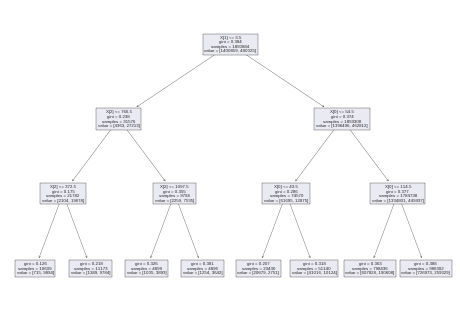

In [ ]:
import matplotlib.pyplot as plt
plot_tree(tree)
plt.show()

GradientBoostingClassifier: As comparison, we can use multiple trees to increase the accuracy and lessen the probability of over-fitting.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
ens_boost = GradientBoostingClassifier(n_estimators=10, learning_rate=1)
ens_boost.fit(X_train, y_train)
print("GradientBoostClassifier training score: {:.3f}".format(ens_boost.score(X_train,y_train)))
print("GradientBoostClassifier test score: {:.3f}".format(ens_boost.score(X_test,y_test)))
display(pd.DataFrame([ens_boost.feature_importances_],columns=X.columns))

GradientBoostClassifier training score: 0.753
GradientBoostClassifier test score: 0.753


,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE
0,0.082619,0.859898,0.057483


From all models, the GradientBoostingClassifier has the highest test and training score without the threat of overfitting. That is why we will evaluate this model with the confusion matrix.

Text(0.5, 427.9555555555555, 'Predicted label')

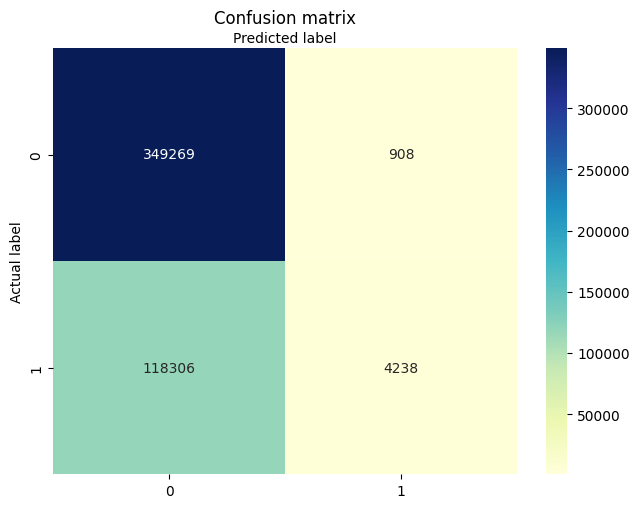

In [ ]:
#construct confusiton matrix 
from sklearn import metrics
y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

import numpy as np
import seaborn as sns
plt.style.use('default')

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
conf = metrics.confusion_matrix(y_test, y_pred, normalize='true')
print("Normalized confusion matrix: \n{}".format(conf))

Normalized confusion matrix: 
[[0.99740703 0.00259297]
 [0.9654165  0.0345835 ]]


As shown in the confusion matrix, the normalized one better visualizes that it the model has a high True Positive and low False Positive.

In [ ]:
print("Precision: {:.3f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {:.3f}".format(metrics.recall_score(y_test, y_pred)))
print("Accuracy: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Precision: 0.824
Recall: 0.035
Accuracy: 0.748


Precision and Accuracy is very high which implies great strength of the model. However since Precision is so high the Recall value is lower. That means that the GradientBoostingClassifier would predict more short delays than it actaully happens. This might be costly for the airport coordination and hence more adjustment and feature enginnering would be necessary to increase this metric.

Based on the coefficients of the logistic regression, none of the chosen variables have a high coefficient meaning that they are all pretty bad predictors of whether a flight is a short or long delay. 

However, using decision tree and gradient boosting classifiers, we can still improve our classification model. 

Looking at the decision tree, air time has the highest of feature importance in determining whether a flight is more likely to have a short or long delay. In contrast, distance and CRS_elapsed time have a value close to 0 indicating that these features were not important to conduct this model. 

Looking at Gradient Boosting Classifier, air time features have the highest degree of importance. This makes sense as longer air time flights have a higher proabibility of being delayed by weather and other factors that can cause the flight to take longer than expected. 

To get even more accurate predictions, we can add additonal integer type variables to the model aswell as standardizing each of the variables.

## Problem 4 [4 points]

Consider we want to cluster airports depending on their properties, such as average number of flights per day, delays, cancellations, etc.

Measure the quality of your clustering result.

In [ ]:
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
import numpy as np
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as f
import pyspark.sql.types
import pandas as pd
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()
sc = SparkContext.getOrCreate()
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import vector_to_array

#MAKE FEATURES OF THE AIRPORTS INTEGER VALUES SO THAT THEY CAN BE USED IN K-MEANS CLUSTERING 
#FOR THE PURPOSES OF OUR CLUSTERING MODEL WE WILL BE USING TOTAL FLIGHTS AND MEAN FLIGHTS PER DAY, MEAN ARRIVAL DELAY, MEAN DEPARTURE DELAY, MEAN CANCELLATIONS, MEAN DISTANCE AND MEAN AIRTIME


#BY AIRPORT, CALCULATE SUM OF FLIGHTS AND MEAN OF FLIGHTS PER DAY

DATE_ORI_DF = spark.sql("SELECT ORIGIN, FL_DATE, count(*) AS count_origin_by_date FROM flights GROUP BY ORIGIN, FL_DATE").createOrReplaceTempView("org_flights")
DATE_DEST_DF = spark.sql("SELECT DEST, FL_DATE, count(*) AS count_dest_by_date FROM flights GROUP BY DEST, FL_DATE").createOrReplaceTempView("dest_flights")
    
airport_flights = spark.sql("SELECT org.ORIGIN AS AIRPORT, org.FL_DATE, count_origin_by_date, dest.count_dest_by_date from org_flights org, dest_flights dest WHERE org.FL_DATE == dest.FL_DATE and org.ORIGIN == dest.DEST")

airport_flights = airport_flights.withColumn("number_of_total_flights", col("count_origin_by_date") + col("count_dest_by_date"))\
            .select("Airport", "number_of_total_flights")

flight_counts = airport_flights.groupBy("Airport").sum("number_of_total_flights").withColumnRenamed("sum(number_of_total_flights)", "Sum_of_flights_dep_arr")
flight_counts = flight_counts.withColumn("Sum_of_flights_dep_arr", func.round(flight_counts["Sum_of_flights_dep_arr"]).cast('integer')).createOrReplaceTempView("flight_counts")

flights_mean = airport_flights.groupBy("Airport").mean("number_of_total_flights").withColumnRenamed("avg(number_of_total_flights)", "Average_flights_dep_arr_per_day")
flights_mean = flights_mean.withColumn("Average_flights_dep_arr_per_day", func.round(flights_mean["Average_flights_dep_arr_per_day"]).cast('integer')).createOrReplaceTempView("flights_mean")



In [ ]:
#BY AIRPORT, MEAN DEPARTURE DELAY
spark.sql("""SELECT * FROM flights""").withColumn("IMP_DEP_DELAY", when(col("DEP_DELAY") < 0, 0)\
                                     .otherwise(col("DEP_DELAY"))).createOrReplaceTempView("delays_dep")

mean_dep_delay = spark.sql("""SELECT dp.ORIGIN AS Airport, MEAN(dp.IMP_DEP_DELAY) AS Avg_Dep_Delay
            FROM delays_dep dp
            GROUP BY Airport""")

mean_dep_delay = mean_dep_delay.withColumn("Avg_Dep_Delay", func.round(mean_dep_delay["Avg_Dep_Delay"]).cast('integer')).createOrReplaceTempView("mean_dep_delay")


#BY AIRPORT, MEAN ARRIVAL DELAY
spark.sql("""SELECT * FROM flights""").withColumn("IMP_ARR_DELAY", when(col("ARR_DELAY") < 0, 0)\
                                     .otherwise(col("ARR_DELAY"))).createOrReplaceTempView("delays_arr")

mean_arr_delay = spark.sql("""SELECT da.DEST AS Airport, MEAN(da.IMP_ARR_DELAY) AS Avg_Arr_Delay
            FROM delays_arr da
            GROUP BY Airport""")
mean_arr_delay = mean_arr_delay.withColumn("Avg_Arr_Delay", func.round(mean_arr_delay["Avg_Arr_Delay"]).cast('integer')).createOrReplaceTempView("mean_arr_delay")


In [ ]:
#BY AIRPORT, MEAN DISTANCE OF FLIGHTS
mean_distance = spark.sql("""SELECT f.ORIGIN AS Airport, MEAN(f.DISTANCE) AS mean_distance_of_flight
            FROM flights f
            GROUP BY Airport""")
mean_distance = mean_distance.withColumn("mean_distance_of_flight", func.round(mean_distance["mean_distance_of_flight"]).cast('integer')).createOrReplaceTempView("mean_distance")

#BY AIRPORT, MEAN CANCELLATION 
mean_cancelled = spark.sql("""SELECT f.ORIGIN AS Airport, MEAN(f.CANCELLED) AS mean_flights_cancelled
            FROM flights f
            GROUP BY Airport""")
mean_cancelled = mean_cancelled.withColumn("mean_flights_cancelled", func.round(mean_cancelled["mean_flights_cancelled"]).cast('integer')).createOrReplaceTempView("mean_cancelled")


In [ ]:
# MERGING FEATURES INTO ONE TABLE
features_airports = spark.sql("""SELECT fc.Airport, fc.Sum_of_flights_dep_arr, fm.Average_flights_dep_arr_per_day, mdd.Avg_Dep_Delay, mad.Avg_Arr_Delay, md.mean_distance_of_flight, mc.mean_flights_cancelled
                            FROM flight_counts fc
                            LEFT JOIN flights_mean fm ON fc.Airport = fm.Airport
                            LEFT JOIN mean_dep_delay mdd ON fc.Airport = mdd.Airport
                            LEFT JOIN mean_arr_delay mad ON fc.Airport = mad.Airport
                            LEFT JOIN mean_distance md ON fc.Airport = md.Airport
                            LEFT JOIN mean_cancelled mc ON fc.Airport = mc.Airport
                            ORDER BY Airport""")

In [ ]:
#USE VECTOR ASSEMBLY TO CREATE ONE COLUMN (VECTOR) FOR ALL OF THE FEATURES 
keep = features_airports.drop('Airport').columns
assembler = VectorAssembler(inputCols=keep, outputCol = 'features_merged')
vector_dat = assembler.transform(features_airports).select('Airport', 'features_merged')
vector_dat.show(5, truncate = False)

+-------+-----------------------------------+
|Airport|features_merged                    |
+-------+-----------------------------------+
|ABE    |[2237.0,17.0,17.0,18.0,594.0,0.0]  |
|ABI    |[1432.0,12.0,15.0,16.0,158.0,0.0]  |
|ABQ    |[20726.0,154.0,12.0,12.0,695.0,0.0]|
|ABR    |[416.0,4.0,5.0,6.0,257.0,0.0]      |
|ABY    |[722.0,5.0,13.0,16.0,145.0,0.0]    |
+-------+-----------------------------------+
only showing top 5 rows



In [ ]:
# USE SCALER TO CENTER THE DATA
scaler = StandardScaler(inputCol="features_merged", outputCol="features_scaled", withStd=False, withMean=True)

# COMPUTE SUMMARY STATS
scalerModel = scaler.fit(vector_dat)

# NORMALIZE FEATURES TO INCLUDE SD
scaledData = scalerModel.transform(vector_dat)
scaledData.select(['Airport', 'features_scaled']).show(5, truncate = False)

+-------+--------------------------------------------------------------------------------------------------------+
|Airport|features_scaled                                                                                         |
+-------+--------------------------------------------------------------------------------------------------------+
|ABE    |[-10573.612466124661,-79.16802168021677,3.50948509485095,4.021680216802164,90.33604336043373,0.0]       |
|ABI    |[-11378.612466124661,-84.16802168021677,1.50948509485095,2.0216802168021637,-345.66395663956627,0.0]    |
|ABQ    |[7915.387533875339,57.83197831978323,-1.49051490514905,-1.9783197831978363,191.33604336043373,0.0]      |
|ABR    |[-12394.612466124661,-92.16802168021677,-8.49051490514905,-7.978319783197836,-246.66395663956627,0.0]   |
|ABY    |[-12088.612466124661,-91.16802168021677,-0.49051490514905005,2.0216802168021637,-358.66395663956627,0.0]|
+-------+-----------------------------------------------------------------------

In [ ]:
#APPLY PCA 
pca = PCA(k=2, inputCol = scaler.getOutputCol(), outputCol="features_PCA")

model = pca.fit(scaledData)
feature_transform = model.transform(scaledData)
feature_transform.show()

+-------+--------------------+--------------------+--------------------+
|Airport|     features_merged|     features_scaled|        features_PCA|
+-------+--------------------+--------------------+--------------------+
|    ABE|[2237.0,17.0,17.0...|[-10573.612466124...|[10573.5056262976...|
|    ABI|[1432.0,12.0,15.0...|[-11378.612466124...|[11380.1165305711...|
|    ABQ|[20726.0,154.0,12...|[7915.38753387533...|[-7916.2480887625...|
|    ABR|[416.0,4.0,5.0,6....|[-12394.612466124...|[12395.7776182583...|
|    ABY|[722.0,5.0,13.0,1...|[-12088.612466124...|[12090.1918539652...|
|    ACK|[1252.0,9.0,20.0,...|[-11558.612466124...|[11559.9856240810...|
|    ACT|[1018.0,10.0,17.0...|[-11792.612466124...|[11794.3522424196...|
|    ACV|[1796.0,14.0,24.0...|[-11014.612466124...|[11015.7871430210...|
|    ACY|[1413.0,13.0,18.0...|[-11397.612466124...|[11396.8239438273...|
|    ADK|[76.0,2.0,15.0,11...|[-12734.612466124...|[12732.3466314579...|
|    ADQ|[488.0,4.0,10.0,7...|[-12322.612466124...|

In [ ]:
### Get 2 PCA features

PCA_DF = feature_transform.withColumn("xs", vector_to_array("features_PCA")).select([col("xs")[i] for i in range(2)])
PCA_DF.show()

+------------------+-------------------+
|             xs[0]|              xs[1]|
+------------------+-------------------+
| 10573.50562629761|  -129.187595660111|
|11380.116530571137| 303.85826208167333|
|-7916.248088762564| -162.2516941073145|
|12395.777618258398| 201.17714785687463|
|12090.191853965236|  314.2574587414967|
|11559.985624081002| 263.19277430381874|
| 11794.35224241968|  366.3281478802346|
| 11015.78714302109|    216.16342033014|
|11396.823943827396| -318.2289764921306|
|12732.346631457936| -735.0959477204957|
|12323.794703725003| 205.42777290514067|
|10419.451143182143| 129.39296773609627|
|10539.093461272367|  302.9294133569887|
|12541.673526784514|   169.632972929601|
|5113.0727968925285|-197.11737271424795|
|12455.889362667409|  229.9230795895958|
| 8282.188976401947|  78.24248410281052|
|-5351.045141576052| -947.6561848049149|
|12495.906307830182| 236.77953317816997|
|12708.448295059523|-161.01679768412487|
+------------------+-------------------+
only showing top

In [ ]:
###Combine features with vector
cols = PCA_DF.columns

assembler = VectorAssembler(inputCols=cols, outputCol = 'features')
vector_dat = assembler.transform(PCA_DF).select('xs[0]', 'xs[1]', 'features')
vector_dat.show(5, truncate = False)

+------------------+------------------+---------------------------------------+
|xs[0]             |xs[1]             |features                               |
+------------------+------------------+---------------------------------------+
|10573.50562629761 |-129.187595660111 |[10573.50562629761,-129.187595660111]  |
|11380.116530571137|303.85826208167333|[11380.116530571137,303.85826208167333]|
|-7916.248088762564|-162.2516941073145|[-7916.248088762564,-162.2516941073145]|
|12395.777618258398|201.17714785687463|[12395.777618258398,201.17714785687463]|
|12090.191853965236|314.2574587414967 |[12090.191853965236,314.2574587414967] |
+------------------+------------------+---------------------------------------+
only showing top 5 rows



In [ ]:
###DETERMINING THE BEST NUMBER OF CLUSTERS TO USE
###TAKES A REALLY LONG TIME TO LOAD (25 MINUTES) BUT BEST K IS 7 WITH CLUSTER QUALITY OF 0.88
###FOR THIS PURPOSE I HAVE SET K TO 7


from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

cluster_qualities = []
bestK = 0
bestQ = -1
#we used for i in range (5,10) initially but seeing as it returns 7, we decreased the range to prevent it running for an extremeley long time (30+ minutes)
for i in range(6, 8):
  kmeans = KMeans().setK(i).setSeed(1)
  model = kmeans.fit(vector_dat)
  predictions = model.transform(vector_dat)
  evaluator = ClusteringEvaluator()
  evaluator.setPredictionCol("prediction")
  currentQ = evaluator.evaluate(predictions)
  cluster_qualities.append(currentQ)
  if currentQ > bestQ:
    bestQ = currentQ
    bestK = i
  else:
    continue

print("Best number of clusters (k):", bestK)
print("Best cluster quality (silhouette score):", bestQ)

Best number of clusters (k): 7
Best cluster quality (silhouette score): 0.8879389553924394


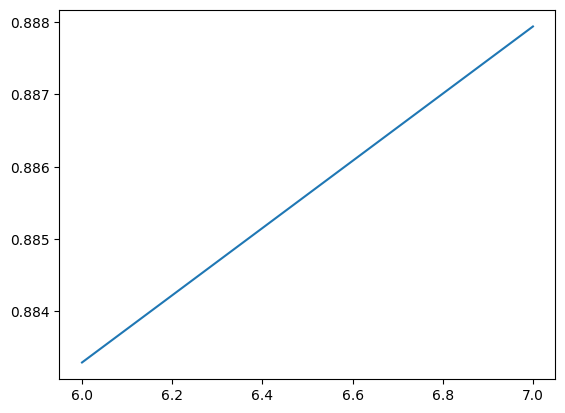

In [ ]:
import matplotlib.pyplot as plt
#plot was also performed over range (5,10); however due to run-time we changed to (6,8). The highest point on the line graph was at K =7).
plt.plot([i for i in range(6, 8)], cluster_qualities)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


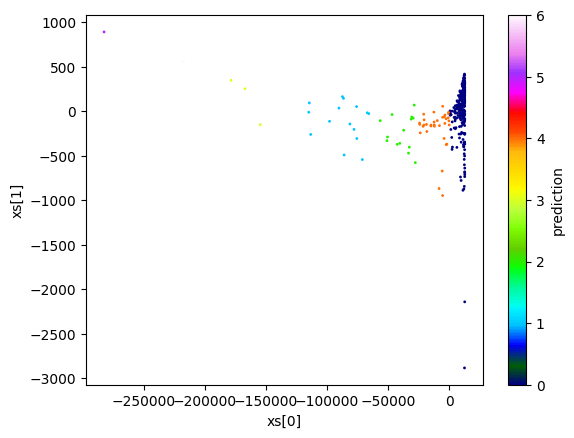

In [ ]:
predictionsPD = predictions.toPandas()

#Display results, cluster number is assigned to color 
predictionsPD.plot.scatter(x="xs[0]",y="xs[1]",c="prediction",s=1,cmap='gist_ncar')

To perform this K-means clustering we started by deciding which features we wanted to cluster airports according. We chose the following properties: count of flights, mean of flights per day, mean dep delay, mean arr delay, mean cancellation and mean distance (a total of 6 variables). We then merged the properties together into one table using left join, then into one column with Vector Assembler. 

Following this initial cleaning, we scaled and standardized the data before using PCA. PCA reduces the dimensionality of our features to two, allowing us to plot our results. 

Following PCA, we use from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator to determine the optimal number of clusters to use, depending on the cluster quality. So, we built a forloop with range (5,10) and determined K=7 as the optimal number of clusters with the highest cluster quality (88%). To reduce runtimes, we reduced the range to (6,8). 

We are satisfied with the quality of our clusters but to improve in the future we can include additional features like the average air duration of flights by airport. In addition, we could remove some of the outliers in the datset to get better centered clusters. 

## Problem 5 [3 points]

We now want to find communities of airports, i.e., airports that are connected based on the flights that exist.

Propose an algorithm to solve this problem and plot the communities as a graph. Run the program with and without GPU support.

In [ ]:
# We followed the advide in the project guidance document, suggesting to cut off routes that account for only ~5% of an airports traffic
# This cell is the first step in this preprocessing, where we identify the overall traffic per airport, by simply counting all incoming an outgoing flights


flights_per_airp = spark.sql("""SELECT origins.id, org_count, dest_count
                                FROM 
                                    (SELECT concat("(", FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))), ",", FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))), ")") as id,
                                    COUNT(*) as org_count
                                    FROM flights
                                    JOIN airports on flights.origin = airports.iata_code
                                    GROUP BY id) as origins
                                JOIN 
                                    (SELECT concat("(", FLOAT(TRIM(SUBSTRING_INDEX(airports.coordinates,',',1))), ",", FLOAT(TRIM(SUBSTRING_INDEX(airports.coordinates,',',-1))), ")") as id,
                                    COUNT(*) as dest_count
                                    FROM flights
                                    JOIN airports on flights.dest = airports.iata_code
                                    GROUP BY id) as destinations
                                ON origins.id = destinations.id""")

flights_per_airp.show()
flights_per_airp.createOrReplaceTempView("airport_totals")


+------------------+---------+----------+
|                id|org_count|dest_count|
+------------------+---------+----------+
|(-80.0405,32.8986)|     5954|      5961|
|(-84.1945,31.5355)|      361|       361|
|(-109.024,44.5202)|      450|       451|
|(-112.012,33.4343)|    63831|     63830|
| (-119.84,34.4262)|     3176|      3177|
|(-135.362,57.0471)|      721|       721|
|(-79.7239,34.1854)|       56|        56|
| (-139.66,59.5033)|      270|       270|
|(-83.2767,30.7825)|      371|       372|
|(-87.3954,46.3536)|      307|       308|
|(-92.2243,34.7294)|     5211|      5208|
| (-159.339,21.976)|     5054|      5054|
|(-76.8916,42.1599)|      482|       481|
|(-98.4698,29.5337)|    13866|     13868|
|(-108.543,45.8077)|     1595|      1600|
|(-124.237,41.7802)|      211|       210|
|(-81.0581,29.1799)|      826|       828|
|(-81.8498,41.4117)|    16651|     16653|
|(-124.109,40.9781)|      897|       899|
|(-84.5874,42.7787)|      942|       943|
+------------------+---------+----

In [ ]:
# The second step of the preprocessing is to count the flights on each route, that can then be further used to calculate the share of traffic of each route


route_counts = spark.sql("""SELECT concat("(", FLOAT(TRIM(SUBSTRING_INDEX(airp1.coordinates,',',1))), ",", FLOAT(TRIM(SUBSTRING_INDEX(airp1.coordinates,',',-1))), ")") as origin_id,
                                   concat("(", FLOAT(TRIM(SUBSTRING_INDEX(airp2.coordinates,',',1))), ",", FLOAT(TRIM(SUBSTRING_INDEX(airp2.coordinates,',',-1))), ")") as dest_id,
                                   count(*) as route_count
                            FROM flights
                            JOIN airports as airp1 on flights.origin = airp1.iata_code
                            JOIN airports as airp2 on flights.dest = airp2.iata_code
                            GROUP BY origin_id, dest_id""")

route_counts.show()
route_counts.createOrReplaceTempView("route_flights")

+------------------+------------------+-----------+
|         origin_id|           dest_id|route_count|
+------------------+------------------+-----------+
|(-77.4558,38.9445)|(-74.1687,40.6925)|        341|
|(-81.8498,41.4117)|(-75.2411,39.8719)|        112|
|(-74.1687,40.6925)|(-95.8881,36.1984)|         70|
|(-77.4558,38.9445)|(-73.1533,44.4719)|        173|
|(-118.408,33.9425)|(-112.012,33.4343)|       3009|
|(-87.9048,41.9786)|(-89.6779,39.8441)|        467|
|(-84.3503,30.3965)|(-84.4281,33.6367)|        974|
| (-93.2218,44.882)|  (-83.994,35.811)|         57|
|(-86.7535,33.5629)| (-97.038,32.8968)|        327|
| (-90.258,29.9934)|(-71.0052,42.3643)|        155|
|(-80.1527,26.0726)|(-84.4281,33.6367)|       2920|
|(-84.4281,33.6367)|(-121.591,38.6954)|        277|
|(-84.4281,33.6367)|(-73.1533,44.4719)|        126|
|(-84.4281,33.6367)| (-96.7592,40.851)|         69|
|(-92.5498,31.3274)| (-97.038,32.8968)|        347|
| (-93.2218,44.882)|(-77.0377,38.8521)|        782|
| (-93.2218,

In [ ]:
# The third step is to merge both tables to create a column that calculates the share of traffic that each route accounts for the involved airports
# For the sake of completeness of the analysis, we do a double merge on both the origin and destination totals, to check whether both fulfill the defined traffic share threshold.
# In the threshold calcultion, we consider ingoing and outgoing traffic separately, comparing the share of all incoming flights on one route with all incoming flights of this route`s destination airport.
# Note that we are using the threshold of 1%. This is because previous runs with a 5% threshold led to loosing a number of airports.
# These are airports, where each single connection is contributing to less than 5% of the overall traffic.
# In order to keep these airports in, we reduced our threshold again. We suggest to optimize the threshold further.

one_perc = spark.sql("""SELECT origin_id, dest_id, route_count, traffic_share_origin, traffic_share_dest
                      FROM (SELECT origin_id, dest_id, route_count, airport_totals1.org_count as total_flights_origin, airport_totals1.dest_count, route_count/airport_totals1.org_count as traffic_share_origin,
                            route_count/airport_totals2.dest_count as traffic_share_dest
                      FROM route_flights
                      JOIN airport_totals as airport_totals1 ON origin_id = airport_totals1.id
                      JOIN airport_totals as airport_totals2 ON dest_id = airport_totals2.id)
                      WHERE traffic_share_origin > 0.01 AND traffic_share_dest > 0.01""")

one_perc.show()

one_perc.createOrReplaceTempView("one_perc")

+------------------+------------------+-----------+--------------------+--------------------+
|         origin_id|           dest_id|route_count|traffic_share_origin|  traffic_share_dest|
+------------------+------------------+-----------+--------------------+--------------------+
|(-74.1687,40.6925)|(-80.0405,32.8986)|        528| 0.01196437878135551| 0.08857574232511324|
|(-77.4558,38.9445)|(-80.0405,32.8986)|        239|0.010537918871252204|  0.0400939439691327|
|(-98.4698,29.5337)|(-112.012,33.4343)|        805|0.058055675753642004|0.012611624627917907|
|(-106.609,35.0402)|(-112.012,33.4343)|       1421|  0.1371489238490493|0.022262259125802913|
|(-76.6683,39.1754)|(-112.012,33.4343)|        739|0.018798809493525984|0.011577628074573085|
|(-115.152,36.0801)|(-112.012,33.4343)|       2501| 0.04519906746426183| 0.03918220272599091|
| (-122.309,47.449)|(-112.012,33.4343)|       1984|0.040196118157137646| 0.03108256305812314|
|(-117.868,33.6757)|(-112.012,33.4343)|       1709| 0.110037

In [ ]:
# Now that we now which routes to drop from the network, we can query the data that we actually need to set up the vector assembler, but exclude the route that do not appear in the five_perc dataset

preprocDF = spark.sql("""SELECT src_long, src_lat, src, dst, dst_long, dst_lat
                      FROM (SELECT FLOAT(TRIM(SUBSTRING_INDEX(airp1.coordinates,',',1))) AS src_long,
                                  FLOAT(TRIM(SUBSTRING_INDEX(airp1.coordinates,',',-1))) AS src_lat,
                                  concat("(", FLOAT(TRIM(SUBSTRING_INDEX(airp1.coordinates,',',1))), ",", FLOAT(TRIM(SUBSTRING_INDEX(airp1.coordinates,',',-1))), ")") as src,
                                  concat("(", FLOAT(TRIM(SUBSTRING_INDEX(airp2.coordinates,',',1))), ",", FLOAT(TRIM(SUBSTRING_INDEX(airp2.coordinates,',',-1))), ")") as dst,
                                  FLOAT(TRIM(SUBSTRING_INDEX(airp2.coordinates,',',1))) AS dst_long,
                                  FLOAT(TRIM(SUBSTRING_INDEX(airp2.coordinates,',',-1))) AS dst_lat
                            

                                  FROM flights JOIN airports as airp1 ON flights.ORIGIN = airp1.iata_code
                                  JOIN airports as airp2 ON flights.DEST = airp2.iata_code
                                  WHERE cancelled=0
                                  AND airp1.continent = 'NA' AND airp1.iso_country = 'US'
                                  AND airp2.continent = 'NA' AND airp2.iso_country = 'US'
                                  AND airp1.type = 'large_airport' 
                                  AND airp2.type = 'large_airport')
                         
                        LEFT JOIN one_perc ON src= one_perc.origin_id AND dst = one_perc.dest_id
                        WHERE one_perc.route_count IS NOT NULL""")

preprocDF.show()

preprocDF.createOrReplaceTempView("data")


+--------+-------+------------------+-----------------+--------+-------+
|src_long|src_lat|               src|              dst|dst_long|dst_lat|
+--------+-------+------------------+-----------------+--------+-------+
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.619)|-122.375| 37.619|
|-112.012|33.4343|(-112.012,33.4343)|(-122.375,37.6

In [ ]:
# creating the edge and vertex dataframes to comply to the graphframes required datastructure

edges = spark.sql("""SELECT src, dst, "trip" from data""")
vertex = spark.sql("""SELECT src as id, src_long as longitude,
                      src_lat as latitude 
                      FROM data
                      UNION
                      SELECT dst as id, dst_long as longitude,
                      dst_lat as latitude 
                      FROM data""")

In [ ]:
from graphframes import *


# Now we are setting up the flow network and run the labelPropagation algorithm

g = GraphFrame(vertex, edges)
results = g.labelPropagation(maxIter=5)

In [ ]:
# Selecting the relevant columns from the results dataframe to plot the community clusters

resultDF = results.select("id", "longitude", "latitude", "label")

In [ ]:
resultDF.show()

+------------------+---------+--------+-------------+
|                id|longitude|latitude|        label|
+------------------+---------+--------+-------------+
|(-122.221,37.7213)| -122.221| 37.7213|1537598291968|
|(-106.609,35.0402)| -106.609| 35.0402|1537598291968|
|(-112.012,33.4343)| -112.012| 33.4343|1537598291968|
|(-81.6879,30.4941)| -81.6879| 30.4941| 584115552256|
|(-80.0405,32.8986)| -80.0405| 32.8986| 584115552256|
| (-117.19,32.7336)|  -117.19| 32.7336|1537598291968|
|(-80.2329,40.4915)| -80.2329| 40.4915| 584115552256|
|(-96.8518,32.8471)| -96.8518| 32.8471|1537598291968|
|(-101.823,33.6636)| -101.823| 33.6636| 584115552256|
|(-121.591,38.6954)| -121.591| 38.6954|1537598291968|
|(-115.152,36.0801)| -115.152| 36.0801|1537598291968|
|(-80.0956,26.6832)| -80.0956| 26.6832| 584115552256|
|(-84.3503,30.3965)| -84.3503| 30.3965| 584115552256|
|(-86.6782,36.1245)| -86.6782| 36.1245| 584115552256|
|(-84.6678,39.0488)| -84.6678| 39.0488| 584115552256|
|(-78.7875,35.8776)| -78.787

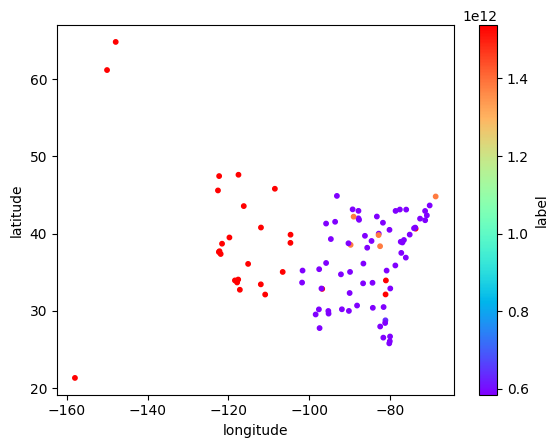

In [ ]:
airportLocPD = resultDF.toPandas()
airportLocPD.plot(x="longitude",y="latitude",c="label",s=10,cmap="rainbow",kind="scatter")

#### Discussion

**Explain your code and discuss results**

We chose the labelPropagation implementation in Graphframes for the community detection task.
We chose this algorithm mostly for the reason of simplicity, as there is an implementation available in the Graphframes extention, and the algorithm comes up with community labels directly. The triangle-count algorithm would for example only identify the count of triangles for each vertex, based on which one would have to further analyse the community structure.

Further we decided to only include the mainland US airports in our community detection analysis, because we expect the remote airports to distort the algorithm slightly and those airports to be of minor importance to the overall network. Only including airports on mainland US also reduces the range of the longitude and latitude values to plot and therefore makes the visualisation of the results much more readable.

As we can see in the plot the algorithm is identifying two clusters, which mainly correspond to the East and West coast. This makes sense, as we would expect airports within those areas to be the more interconnected. Nevertheless, we suggest to further optimize the threshold value to allow the algorithm to identify more granular clusters. As already explained, we have set a threshold value of 5% first, which resulted in a much larger number of community clusters (6). We were not happy with the loss of some airports though and therefore reduced the threshold again.

Ideally, we would have experimented in the preprocessing with different threshold values. For the sake of time management, used the proposed traffic share threshold of 5%, when noticing the loss of a number of airports though we decided to use a threshold of 1%. However, it would be important for the analysis to check the community results if we change the threshold.
Since raising the threshold corresponds to "cleaning" the network from unimportant route connections, we would expect the result to be more distinguished.




In [ ]:
start_time = time.time()

g = GraphFrame(vertex, edges)
results = g.labelPropagation(maxIter=5)


end_time = time.time()
print( "Runtime = " + str(end_time - start_time))

Runtime = 678.580902338028


In [ ]:
start_time = time.time()

g = GraphFrame(vertex, edges)
results = g.labelPropagation(maxIter=5)


end_time = time.time()
print( "Runtime = " + str(end_time - start_time))

Runtime = 698.8427171707153


We ran the algorithm with and without GPU support and recieved very similiar runtimes. A difference of only 20 seconds, however in both cases the algorithm took over 10 minutes to run. 

